In [84]:
import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random
import arviz as az

In [161]:
alphas = np.random.normal(0, 2, 4)
betas = np.random.normal(10, 2, 4)
print(f"alphas: {alphas}")
print(f"betas: {betas}")

alphas: [2.33221589 2.18290379 1.13920902 0.4710965 ]
betas: [11.15626234 11.31077675 10.6714271  14.61636812]


In [162]:
# Create simulated data
x = np.random.normal(0, 5, 1000)
y1 = alphas[0] + betas[0] * x[:250] + np.random.normal(0, 2, 250)
y2 = alphas[1] + betas[1] * x[250:500] + np.random.normal(0, 3, 250)
y3 = alphas[2] + betas[2] * x[500:750] + np.random.normal(0, 5, 250)
y4 = alphas[3] + betas[3] * x[750:] + np.random.normal(0, 7, 250)
y = np.concatenate([y1, y2, y3, y4])
ind = np.concatenate([np.zeros(250), np.ones(250), np.ones(250) * 2, np.ones(250) * 3]).astype(int)

In [163]:
# Shuffle the data
dataset = np.array([x, ind, y])
np.random.shuffle(dataset.T)
x, ind, y = dataset
ind = ind.astype(int)

In [164]:
def model(x, ind, y):
    # hiperpriors
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 10))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(10))
    mu_b = numpyro.sample("mu_b", dist.Normal(10, 5))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(10))
    # rate = numpyro.sample("rate", dist.HalfNormal(10))

    # priors
    with numpyro.plate("ind", 4):
        offset_a = numpyro.sample("offset_a", dist.Normal(0, 1))
        a = numpyro.deterministic("a", mu_a + offset_a * sigma_a)
        offset_b = numpyro.sample("offset_b", dist.Normal(0, 1))
        b = numpyro.deterministic("b", mu_b + offset_b * sigma_b)
    sigma = numpyro.sample("sigma", dist.HalfNormal(10))
        # offset_sigma = numpyro.sample("offset_sigma", dist.Normal(0, 1))
        # sigma = numpyro.deterministic("sigma", rate + jnp.exp(offset_sigma))
    # Expected value
    mu = a[ind] + b[ind] * x
    error = sigma
    
    # likelihood
    numpyro.sample("y", dist.Normal(mu, error), obs=y)

In [165]:
rng_key = random.PRNGKey(0)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1200, num_samples=1000, num_chains=4, chain_method='vectorized')
mcmc.run(rng_key, x, ind, y)

sample: 100%|██████████| 2200/2200 [07:01<00:00,  5.22it/s]


In [166]:
az.summary(az.from_numpyro(mcmc), round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],2.391,0.299,1.817,2.943,0.005,0.003,3696.153,3083.102,1.000
a[1],2.208,0.297,1.640,2.749,0.005,0.003,3814.421,2951.379,1.001
a[2],1.302,0.294,0.761,1.849,0.005,0.003,4291.055,2882.657,1.000
a[3],0.744,0.305,0.159,1.296,0.005,0.004,3515.550,3157.081,1.000
b[0],11.129,0.067,11.010,11.264,0.001,0.001,4116.696,3194.339,1.001
b[1],11.301,0.057,11.190,11.404,0.001,0.001,4182.690,3581.368,1.001
b[2],10.662,0.064,10.543,10.785,0.001,0.001,4021.825,3410.132,1.001
b[3],14.518,0.060,14.407,14.635,0.001,0.001,3841.901,2966.650,1.002
mu_a,1.614,0.972,-0.061,3.575,0.028,0.025,1349.018,1293.643,1.004
mu_b,11.787,1.345,8.973,14.205,0.042,0.030,1024.348,1251.534,1.004


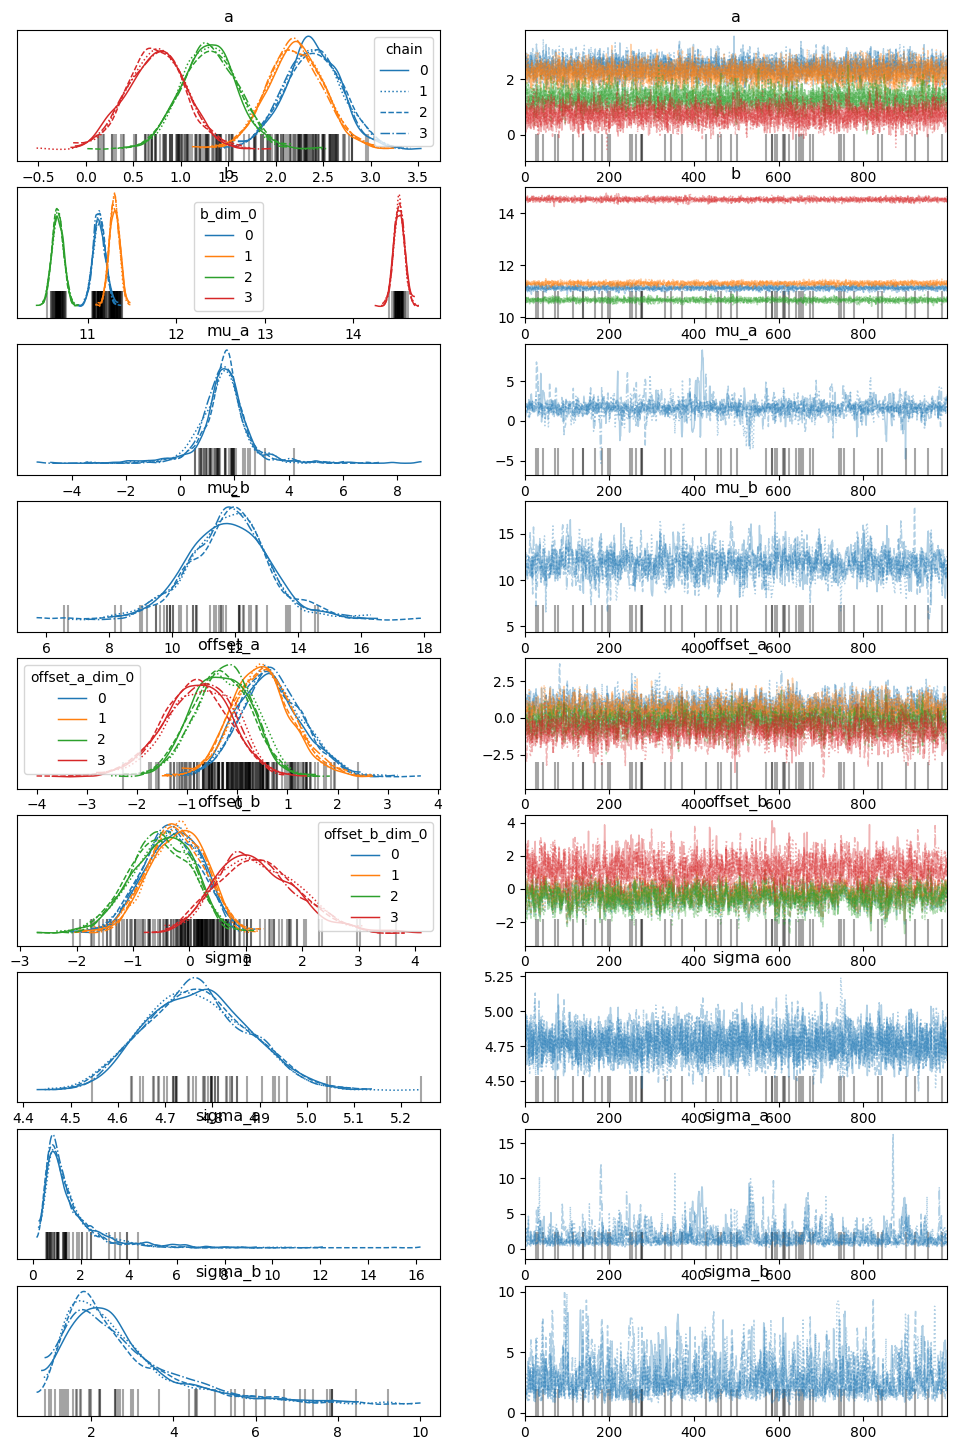

In [167]:
az.plot_trace(az.from_numpyro(mcmc), legend=True, combined=False);